### 업비트 API를 활용한 코인가격변동 예측 모형 개발
* 작성일 : 2022-04-08
* 작성자 : 윤성준
* 버전 : 0.1
* 변경이력 

## 목차
1. 데이터 수집
2. 항목 생성
3. 요건 정의 (dev/val, target 등)
4. ML모델학습
5. 평가
---

1. 데이터 수집

In [1]:
import pyupbit
import os
import pandas as pd
import pickle
from datetime import datetime
from dateutil.relativedelta import relativedelta
import talib
from talib import abstract
import cb_001m_upbit

In [2]:
tickers = pyupbit.get_tickers(fiat="KRW")
print(tickers)

['KRW-BTC', 'KRW-ETH', 'KRW-NEO', 'KRW-MTL', 'KRW-LTC', 'KRW-XRP', 'KRW-ETC', 'KRW-OMG', 'KRW-SNT', 'KRW-WAVES', 'KRW-XEM', 'KRW-QTUM', 'KRW-LSK', 'KRW-STEEM', 'KRW-XLM', 'KRW-ARDR', 'KRW-ARK', 'KRW-STORJ', 'KRW-GRS', 'KRW-REP', 'KRW-ADA', 'KRW-SBD', 'KRW-POWR', 'KRW-BTG', 'KRW-ICX', 'KRW-EOS', 'KRW-TRX', 'KRW-SC', 'KRW-ONT', 'KRW-ZIL', 'KRW-POLY', 'KRW-ZRX', 'KRW-LOOM', 'KRW-BCH', 'KRW-BAT', 'KRW-IOST', 'KRW-RFR', 'KRW-CVC', 'KRW-IQ', 'KRW-IOTA', 'KRW-MFT', 'KRW-ONG', 'KRW-GAS', 'KRW-UPP', 'KRW-ELF', 'KRW-KNC', 'KRW-BSV', 'KRW-THETA', 'KRW-QKC', 'KRW-BTT', 'KRW-MOC', 'KRW-ENJ', 'KRW-TFUEL', 'KRW-MANA', 'KRW-ANKR', 'KRW-AERGO', 'KRW-ATOM', 'KRW-TT', 'KRW-CRE', 'KRW-MBL', 'KRW-WAXP', 'KRW-HBAR', 'KRW-MED', 'KRW-MLK', 'KRW-STPT', 'KRW-ORBS', 'KRW-VET', 'KRW-CHZ', 'KRW-STMX', 'KRW-DKA', 'KRW-HIVE', 'KRW-KAVA', 'KRW-AHT', 'KRW-LINK', 'KRW-XTZ', 'KRW-BORA', 'KRW-JST', 'KRW-CRO', 'KRW-TON', 'KRW-SXP', 'KRW-HUNT', 'KRW-PLA', 'KRW-DOT', 'KRW-SRM', 'KRW-MVL', 'KRW-STRAX', 'KRW-AQT', 'KRW-GLM', 

In [3]:
WORKDATE = '2022-04-01'
REQMONTHS = 7

workdate = datetime.fromisoformat(WORKDATE)
startdate = workdate - relativedelta(months=REQMONTHS)

In [5]:
ohlcvs = cb_001m_upbit.get_ohlcv_dump(tickers = tickers, filename = 'data.pickle', workdate = workdate, reqmonths = REQMONTHS)

2. 데이터 정제

In [6]:
for key, val in ohlcvs.items():
    print(key, val.size)

KRW-BTC 1826814
KRW-ETH 1826502
KRW-NEO 1716108
KRW-MTL 1536216
KRW-LTC 1672956
KRW-XRP 1826754
KRW-ETC 1813032
KRW-OMG 1737996
KRW-SNT 1602306
KRW-WAVES 1704420
KRW-XEM 1476048
KRW-QTUM 1761078
KRW-LSK 1462116
KRW-STEEM 1488834
KRW-XLM 1735842
KRW-ARDR 1445334
KRW-ARK 1464846
KRW-STORJ 1581816
KRW-GRS 1376070
KRW-REP 1449246
KRW-ADA 1811994
KRW-SBD 1353252
KRW-POWR 1685922
KRW-BTG 1629966
KRW-ICX 1668246
KRW-EOS 1788900
KRW-TRX 1810698
KRW-SC 1563060
KRW-ONT 1550724
KRW-ZIL 1551738
KRW-POLY 1599582
KRW-ZRX 1424304
KRW-LOOM 1467552
KRW-BCH 1654794
KRW-BAT 1651668
KRW-IOST 1458768
KRW-RFR 1388598
KRW-CVC 1581660
KRW-IQ 1310058
KRW-IOTA 1476150
KRW-MFT 1449816
KRW-ONG 1575312
KRW-GAS 1552836
KRW-UPP 1354794
KRW-ELF 1613814
KRW-KNC 1610424
KRW-BSV 1532196
KRW-THETA 1591764
KRW-QKC 1389702
KRW-BTT 1755510
KRW-MOC 1544514
KRW-ENJ 1656336
KRW-TFUEL 1603488
KRW-MANA 1802304
KRW-ANKR 1557480
KRW-AERGO 1543176
KRW-ATOM 1799424
KRW-TT 1438518
KRW-CRE 1528842
KRW-MBL 1547706
KRW-WAXP 1692864
KRW-

In [7]:
assert isinstance(ohlcvs['KRW-BTC'].index, pd.DatetimeIndex), 'not datetime index'

In [8]:
ohlcvs['KRW-BTC']

,open,high,low,close,volume,value
2021-09-01 00:00:00,55326000.0,55422000.0,55326000.0,55327000.0,16.458649,9.113422e+08
2021-09-01 00:01:00,55327000.0,55399000.0,55327000.0,55393000.0,9.624262,5.327570e+08
2021-09-01 00:02:00,55400000.0,55477000.0,55391000.0,55443000.0,12.328954,6.834197e+08
2021-09-01 00:03:00,55439000.0,55463000.0,55343000.0,55350000.0,18.474244,1.023428e+09
2021-09-01 00:04:00,55378000.0,55385000.0,55331000.0,55340000.0,12.750241,7.056209e+08
...,...,...,...,...,...,...
2022-03-31 23:55:00,56461000.0,56485000.0,56461000.0,56481000.0,7.931584,4.479158e+08
2022-03-31 23:56:00,56480000.0,56490000.0,56480000.0,56490000.0,4.296142,2.426775e+08
2022-03-31 23:57:00,56490000.0,56499000.0,56485000.0,56488000.0,5.051226,2.853419e+08
2022-03-31 23:58:00,56489000.0,56505000.0,56486000.0,56499000.0,3.184290,1.799036e+08


In [10]:
tot_idx = pd.date_range(start = startdate , end = workdate, freq = 'T', closed = 'left')

tot_set = cb_001m_upbit.get_tot_df(ohlcvs = ohlcvs, tot_idx = tot_idx
                , filename = r"D:\2022\CoinbizExpert\data_feature.pickle"
                , force_download = False)

MemoryError: Unable to allocate 468. MiB for an array with shape (201, 305280) and data type float64

In [ ]:
# 7개월간 데이터가 있는 102개 코인으로 축소 (11개 코인 제거)
tot_set.columns


Index(['KRW-BTC-volume', 'KRW-BTC-upperband10', 'KRW-BTC-middleband10',
       'KRW-BTC-lowerband10', 'KRW-BTC-dema10', 'KRW-BTC-ema10',
       'KRW-BTC-kama10', 'KRW-BTC-midpoint10', 'KRW-BTC-midprice10',
       'KRW-BTC-t310',
       ...
       'KRW-BTC-CDLSTALLEDPATTERN', 'KRW-BTC-CDLSTICKSANDWICH',
       'KRW-BTC-CDLTAKURI', 'KRW-BTC-CDLTASUKIGAP', 'KRW-BTC-CDLTHRUSTING',
       'KRW-BTC-CDLTRISTAR', 'KRW-BTC-CDLUNIQUE3RIVER',
       'KRW-BTC-CDLUPSIDEGAP2CROWS', 'KRW-BTC-CDLXSIDEGAP3METHODS',
       'KRW-BTC-target'],
      dtype='object', length=296)

3. 모형 개발

In [ ]:
# from ta import add_all_ta_features

# # Load datas
# df = ohlcvs['KRW-BTC'].copy() # this is you data and it has to be in the OHLC and volume format 

# # Add ta features filling NaN values
# df = add_all_ta_features(
#     df, open="open", high="high", low="low", close="close", volume="volume", fillna=True)

# df.columns

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
# tot_set.drop(columns=['val_gb'], inplace=True)
# t = ohlcvs['KRW-BTC']

In [ ]:
tot_set['train_gb'] = np.where((tot_set.index >= datetime.fromisoformat('2021-10-01')) \
                            & (tot_set.index < datetime.fromisoformat('2021-12-01')),1,0)

tot_set['test_gb'] = np.where((tot_set.index >= datetime.fromisoformat('2021-12-01')) \
                            & (tot_set.index < datetime.fromisoformat('2022-02-01')),1,0)

tot_set['val_gb'] = np.where((tot_set.index >= datetime.fromisoformat('2022-02-01')) \
                            & (tot_set.index < datetime.fromisoformat('2022-03-31 23:49:00')),1,0)

tot_set['target'] = np.where(tot_set['KRW-BTC-target'] >= 1,1,0)

In [ ]:
print(tot_set.train_gb.sum()/60/24)
print(tot_set.test_gb.sum()/60/24)
print((tot_set.val_gb.sum()+11)/60/24) # 마지막 11개 데이터는 퍼포먼스 미확보로 미사용
print((tot_set['train_gb']==1).sum())
print(((tot_set['target']==1) & (tot_set['train_gb']==1)).sum())
print((tot_set['test_gb']==1).sum())
print(((tot_set['target']==1) & (tot_set['test_gb']==1)).sum())
print((tot_set['val_gb']==1).sum())
print(((tot_set['target']==1) & (tot_set['val_gb']==1)).sum())
print(((tot_set['target']==1) & (tot_set['train_gb']==1)).sum()/(tot_set['train_gb']==1).sum())
print(((tot_set['target']==1) & (tot_set['test_gb']==1)).sum()/(tot_set['test_gb']==1).sum())
print(((tot_set['target']==1) & (tot_set['val_gb']==1)).sum()/(tot_set['val_gb']==1).sum())

# tot_set[(tot_set['target']==1)]
tot_set_1min = tot_set[tot_set.index.minute%10==1]

61.0
62.0
59.0
87840
345
89280
451
84949
369
0.003927595628415301
0.005051523297491039
0.0043437827402323746


In [ ]:
X_train = tot_set_1min[tot_set_1min.train_gb == 1].drop(['KRW-BTC-target','target','val_gb','test_gb','train_gb'], axis=1)
y_train = tot_set_1min[tot_set_1min.train_gb == 1]['target']
X_test = tot_set_1min[tot_set_1min.test_gb == 1].drop(['KRW-BTC-target','target','val_gb','test_gb','train_gb'], axis=1)
y_test = tot_set_1min[tot_set_1min.test_gb == 1]['target']
X_val = tot_set_1min[tot_set_1min.val_gb == 1].drop(['KRW-BTC-target','target','val_gb','test_gb','train_gb'], axis=1)
y_val = tot_set_1min[tot_set_1min.val_gb == 1]['target']


In [ ]:
model = RandomForestClassifier(n_estimators=50, max_depth=60, n_jobs=-1)

model.fit(X_train,y_train)

RandomForestClassifier(max_depth=60, n_estimators=50, n_jobs=-1)

In [ ]:
rf_train_rslt = pd.DataFrame(y_train)
rf_train_rslt['pred_target'] = model.predict(X_train)
rf_test_rslt = pd.DataFrame(y_test)
rf_test_rslt['pred_target'] = model.predict(X_test)
rf_val_rslt = pd.DataFrame(y_val)
rf_val_rslt['pred_target'] = model.predict(X_val)


rf_train_rslt.to_csv('train_rslt.csv', index=False)
rf_test_rslt.to_csv('test_rslt.csv', index=False)
rf_val_rslt.to_csv('val_rslt.csv', index=False)

In [ ]:
import lightgbm
import bayes_opt

In [ ]:
def bayes_train(n_estimators, max_depth, min_child_weight, subsample, colsample_bytree, learning_rate):
    clf = lightgbm.LGBMClassifier(random_state = 0, device = 'cpu', n_jobs = -1
                                , n_estimators=int(n_estimators)
                                , max_depth=int(max_depth)
                                , num_leaves=7
                                , min_child_weight = min_child_weight
                                , subsample = subsample
                                , colsample_bytree = colsample_bytree
                                , learning_rate = learning_rate)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    score = f1_score(y_test, preds)
    
    return score

pbounds = {'n_estimators' : (10, 700)
            , 'max_depth' : (1, 3)
            , 'min_child_weight' : (0.1, 1)
            , 'subsample' : (0.5, 1)
            , 'colsample_bytree' : (0.5, 1)
            , 'learning_rate' : (0.001, 0.3)}
optimizer = bayes_opt.BayesianOptimization(f = bayes_train, pbounds= pbounds, random_state=0)
optimizer.maximize(init_points=100, n_iter = 100)
opt_res_lgbm = pd.DataFrame(optimizer.res)


|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
|  1        |  0.0      |  0.7744   |  0.2148   |  2.206    |  0.5904   |  302.3    |  0.8229   |
|  2        |  0.03922  |  0.7188   |  0.2676   |  2.927    |  0.4451   |  556.3    |  0.7644   |
|  3        |  0.1458   |  0.784    |  0.2778   |  1.142    |  0.1784   |  23.95    |  0.9163   |
|  4        |  0.04     |  0.8891   |  0.2611   |  2.957    |  0.8192   |  328.4    |  0.8903   |
|  5        |  0.03846  |  0.5591   |  0.1923   |  1.287    |  0.9502   |  370.1    |  0.7073   |
|  6        |  0.03509  |  0.6323   |  0.2325   |  1.912    |  0.6116   |  22.96    |  0.8088   |
|  7        |  0.04     |  0.806    |  0.1855   |  2.887    |  0.7136   |  258.1    |  0.7185   |
|  8        |  0.0      |  0.8488   |  0.01901  |  2.334    |  0.7036   |  155.2    |  0.5645   |
|  9        |  0.078

In [ ]:
for cols in ['n_estimators', 'max_depth', 'min_child_weight', 'subsample', 'colsample_bytree', 'learning_rate']:
    md = []
    for i in np.arange(opt_res_lgbm.shape[0]):
        md.append(opt_res_lgbm['params'][i][cols])
    opt_res_lgbm[cols] = md

In [ ]:
i = 53
final_model_lgbm = lightgbm.LGBMClassifier(random_state = 0, device = 'cpu', n_jobs = -1
                                , n_estimators=int(opt_res_lgbm['n_estimators'][i])
                                , max_depth=int(opt_res_lgbm['max_depth'][i])
                                , num_leaves=7
                                , min_child_weight = opt_res_lgbm['min_child_weight'][i]
                                , subsample = opt_res_lgbm['subsample'][i]
                                , colsample_bytree = opt_res_lgbm['colsample_bytree'][i]
                                , learning_rate = opt_res_lgbm['learning_rate'][i])
final_model_lgbm.fit(X_val, y_val)
f1_score(y_val, final_model_lgbm.predict(X_val))

0.047619047619047616

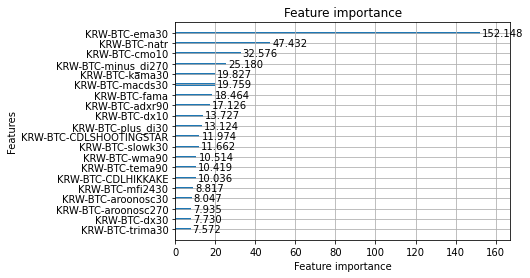

In [ ]:
lightgbm.plot_importance(final_model_lgbm, importance_type='gain', max_num_features=20)
fi_df_lgbm = pd.DataFrame(data = final_model_lgbm.booster_.feature_importance(importance_type='gain'), index = X_val.columns, columns = ['FI'])


In [ ]:
rf_train_rslt = pd.DataFrame(y_train)
rf_train_rslt['pred_target'] = final_model_lgbm.predict(X_train)
rf_test_rslt = pd.DataFrame(y_test)
rf_test_rslt['pred_target'] = final_model_lgbm.predict(X_test)
rf_val_rslt = pd.DataFrame(y_val)
rf_val_rslt['pred_target'] = final_model_lgbm.predict(X_val)


rf_train_rslt.to_csv('train_rslt.csv', index=False)
rf_test_rslt.to_csv('test_rslt.csv', index=False)
rf_val_rslt.to_csv('val_rslt.csv', index=False)

In [ ]:

fi_df_lgbm['f'] = fi_df_lgbm.index
fi_df_lgbm.to_csv('fi_df_lgbm.csv', index=False)